# Conexión a cubos dinámicos de la DGIS de la Secretaría de Salud (México)
> "Pasos para conectarse a los cubos dinámicos de la DGIS de la Secretaría de Salud"
- toc: false
- badges: false
- comments: true
- categories: [python, dgis, datos]
- permalink: /dgis-conexion/

> Elaborado por Juan Javier Santos Ochoa ([@jjsantoso](https://twitter.com/jjsantoso))

# Introducción

La Secretaría de Salud (SSA) de México publica muchos de sus datos abiertos a través de cubos dinámicos. Si bien los cubos dinámicos tienen la ventaja de que permiten a los usuarios construir consultas complejas, lo cierto es que la tecnologia que usa la SSA es muy antigua y hace prácticamente inaccesibles los datos. Según la [guía de instalación](http://www.dgis.salud.gob.mx/descargas/pdf/Guia_de_Instalacion_Cubosvf.pdf), es necesario usar el navegador Internet Explorer ([que ya fue descontinuado por Microsoft](https://www.muycomputer.com/2022/06/14/internet-explorer-dice-adios/)) y además instalar al menos 4 programas y complementos en el navegador. El proceso es simplemente anacrónico.

Para facilitar el acceso a los cubos y poder obtener un acceso a los datos mucho más detallado, me dí a la tarea de buscar una forma de conectarme directamente a los cubos sin necesidad de usar el tedioso proceso de instalación. A continuación detallo los pasos de cómo lo logré usando Python.

# Pasos para la conexión

Primero que todo, es necesario instalar [adobapi](https://pypi.org/project/adodbapi/)
```
pip install adodbapi
```

In [1]:
import pandas as pd
import adodbapi


def rows_to_df(rows) -> pd.DataFrame:
    """ 
    Convierte los resultados de una consulta de adobdapi a un DataFrame de Pandas.
    rows: resultado de la consulta
    """
    df = pd.DataFrame(data=dict(zip(rows.columnNames.keys(), rows.ado_results)))\
        .assign(_id=lambda x: range(len(x)))
    return df

* Se necesita descargar el driver de MSOLAP (amd64): https://docs.microsoft.com/en-us/analysis-services/client-libraries?view=asallproducts-allversions&viewFallbackFrom=sql-server-2017. No he probado en otros sitemas operativos, pero me parece que solo se puede con Windows.

* Es posible que también haya que instalar los drivers que especifica la páginas de DGIS en las instrucciones de instalación (a mí me funcionó sin estos).

* Usamos `adodbapi` para establecer una conexión con el servidor
* Es necesario especificar la base de datos que se va a consultar, por ejemplo, este es la de muertes maternas.

In [2]:
cubo = 'MATERNAS_2020'
conn = adodbapi.connect('Provider=MSOLAP.8;Password=Temp123!;Persist Security Info=True;User ID=SALUD\DGIS15;'
                        f'Data Source=pwidgis03.salud.gob.mx;Update Isolation Level=2;Initial Catalog={cubo}')
cursor = conn.cursor()

Una vez establecida la conexión, se pueden hacer queries usando el lenguaje MDX, que usa algunos comando básicos de SQL aunque es mucho más difícil.

https://docs.microsoft.com/en-us/analysis-services/multidimensional-models/mdx/mdx-query-the-basic-query?view=asallproducts-allversions

La siguiente query permite conocer todas las bases de datos disponibles:

In [3]:
cursor.execute("""SELECT [catalog_name] FROM $system.DBSCHEMA_CATALOGS""")
rows = cursor.fetchall()
list(rows)

[<SQLrow={catalog_name:'CLUES_2019'}>,
 <SQLrow={catalog_name:'CLUES_2019_C'}>,
 <SQLrow={catalog_name:'CONAPO_NACIMIENTOS'}>,
 <SQLrow={catalog_name:'Cubo solo sinba 2020'}>,
 <SQLrow={catalog_name:'Cubo solo sinba 2021'}>,
 <SQLrow={catalog_name:'Cubo solo sinba 2022'}>,
 <SQLrow={catalog_name:'cubo_lesiones_2017'}>,
 <SQLrow={catalog_name:'cubo_lesiones_2018'}>,
 <SQLrow={catalog_name:'Cubo_Lesiones2019'}>,
 <SQLrow={catalog_name:'Cubo_pobla_2019_DH'}>,
 <SQLrow={catalog_name:'CuboLesiones2020'}>,
 <SQLrow={catalog_name:'CuboLesiones2021'}>,
 <SQLrow={catalog_name:'CuboLesiones2022'}>,
 <SQLrow={catalog_name:'CuboSec_18_20'}>,
 <SQLrow={catalog_name:'CuboSectorial_18_19'}>,
 <SQLrow={catalog_name:'CuboSectorial_18_20'}>,
 <SQLrow={catalog_name:'Defunciones_hist'}>,
 <SQLrow={catalog_name:'DEFUNCIONES_PC_2020'}>,
 <SQLrow={catalog_name:'DERECHOHABIENCIA'}>,
 <SQLrow={catalog_name:'Detecciones'}>,
 <SQLrow={catalog_name:'EGRESOS'}>,
 <SQLrow={catalog_name:'egresos_procedimientos_sinba

En nuestro caso, ya escogimos la base de datos "MATERNAS_2020" con los datos de mortalidad materna del año 2022.

La siguiente query sirve para conocer los cubos y dimensiones de esta base de datos:

In [4]:
cursor.execute("""
SELECT [CATALOG_NAME] as [DATABASE],
CUBE_NAME AS [CUBE], DIMENSION_CAPTION AS [DIMENSION]
FROM $system.MDSchema_Dimensions
WHERE DIMENSION_CAPTION='Measures'
""")
rows = cursor.fetchall()
df_cubos_maternas = rows_to_df(rows)
df_cubos_maternas

,database,cube,dimension,_id
0,Maternas_2020,$AFILIACION,Measures,0
1,Maternas_2020,$AÑO CERTIFICACION,Measures,1
2,Maternas_2020,$AÑO DEFUNCION,Measures,2
3,Maternas_2020,$AÑO REGISTRO,Measures,3
4,Maternas_2020,$ASISTENCIA MEDICA,Measures,4
5,Maternas_2020,$CAUSA BASICA,Measures,5
6,Maternas_2020,$CERTIFICO,Measures,6
7,Maternas_2020,$EDAD,Measures,7
8,Maternas_2020,$EDADD,Measures,8
9,Maternas_2020,$ENTIDAD DEFUNCION,Measures,9


* de estos cubos, casi todos empiezan con el símbolo $ \$ $, excepto uno. Lo que he notado es que este cubo es el que tenemos que usar para hacer las consultas de los datos de interés. En este caso, por ejemplo, se trata del cubo "MUERTES MATERNAS"

In [5]:
df_cubos_maternas['cube'].loc[lambda x: ~ x.str.contains(r'\$')]

20    MUERTES MATERNAS
Name: cube, dtype: object

[MDX](https://www.codeproject.com/Articles/710387/Learn-to-Write-Custom-MDX-Query-First-Time) permite hacer consultas con gran nivel de detalle, pero a mí me parece complicado. Considero más fácil descargar toda la información y luego hacer las agregaciones usando Python:

In [6]:
cursor.execute("""
SELECT *
FROM [MUERTES MATERNAS].[Measures]
""")
rows = cursor.fetchall()
df = rows_to_df(rows)
df

,[totales].[$afiliacion.afiliación derechohabiencia],[totales].[$año certificacion.año de certificación],[totales].[$año defuncion.año de la defunción],[totales].[$año registro.año de registro],[totales].[$asistencia medica.asistencia médica],[totales].[$entidad defuncion.entidad de defunción],[totales].[$entidad residencia.entidad de residencia],[totales].[$escolaridad.escolaridad],[totales].[$estado civil.estado civil],[totales].[$mes certificacion.mes de la certificación],...,[totales].[$certifico.quién certificó],[totales].[$razon mortalidad.razón mortalidad materna],[totales].[$sitio ocurrencia.sitio de ocurrencia],[totales].[$tamaño localidad.tamaño de localidad],[totales].[$edad.edad quinquenal],[totales].[$edadd.edad],[totales].[$causa basica.cve causa 4],[totales].[$principales causas.clave pcm],[totales].[muertes maternas],_id
0,NO ESPECIFICADA,2019,2019,2019,NO ESPECIFICADO,CHIAPAS,CHIAPAS,NO ESPECIFICADA,SE IGNORA,SEPTIEMBRE,...,NO ESPECIFICADO,MUERTES MATERNAS PARA LA RAZÓN DE MORTALIDAD M...,OTRO LUGAR,1000 A 1999 HABITANTES,30 a 34 años,None,O432 PLACENTA ANORMALMENTE ADHERIDA,43G,1,0
1,SEGURO POPULAR,2019,2019,2019,SIN ATENCION MEDICA,CHIHUAHUA,CHIHUAHUA,NINGUNA,UNION LIBRE,OCTUBRE,...,MEDICO LEGISTA,MUERTES MATERNAS PARA LA RAZÓN DE MORTALIDAD M...,VIA PUBLICA,1 A 999 HABITANTES,30 a 34 años,None,O720 HEMORRAGIA DEL TERCER PERÍODO DEL PARTO,43K,1,1
2,IMSS,2019,2019,2019,CON ATENCION MEDICA,JALISCO,JALISCO,BACHILLERATO O PREPARATORIA COMPLETA,CASADO,ABRIL,...,OTRO MEDICO,MUERTES MATERNAS PARA LA RAZÓN DE MORTALIDAD M...,IMSS,1000000 A 1499999 HABITANTES,35 a 39 años,None,O021 ABORTO RETENIDO,43C,1,2
3,SEGURO POPULAR,2019,2019,2019,CON ATENCION MEDICA,JALISCO,JALISCO,SECUNDARIA COMPLETA,CASADO,MARZO,...,OTRO MEDICO,MUERTES MATERNAS EXCLUIDAS PARA LA RAZÓN DE MO...,OTRO LUGAR,10000 A 14999 HABITANTES,20 a 24 años,None,O961 MUERTE POR CAUSA OBSTÉTRICA INDIRECTA QUE...,4543,1,3
4,SEGURO POPULAR,2019,2019,2019,CON ATENCION MEDICA,JALISCO,JALISCO,SECUNDARIA COMPLETA,CASADO,ABRIL,...,MEDICO TRATANTE,MUERTES MATERNAS PARA LA RAZÓN DE MORTALIDAD M...,SECRETARIA DE SALUD,10000 A 14999 HABITANTES,30 a 34 años,None,O223 FLEBOTROMBOSIS PROFUNDA EN EL EMBARAZO,43N,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21119,NO ESPECIFICADA,2020,2020,2020,CON ATENCION MEDICA,SINALOA,SINALOA,PROFESIONAL,CASADO,JULIO,...,OTRO MEDICO,MUERTES MATERNAS PARA LA RAZÓN DE MORTALIDAD M...,IMSS,500000 A 999999 HABITANTES,20 a 24 años,None,O985 OTRAS ENFERMEDADES VIRALES QUE COMPLICAN ...,45,1,21119
21120,IMSS,2020,2020,2020,CON ATENCION MEDICA,SINALOA,SINALOA,PROFESIONAL,SE IGNORA,OCTUBRE,...,OTRO MEDICO,MUERTES MATERNAS PARA LA RAZÓN DE MORTALIDAD M...,IMSS,500000 A 999999 HABITANTES,30 a 34 años,None,O996 ENFERMEDADES DEL SISTEMA DIGESTIVO QUE CO...,45,1,21120
21121,IMSS,2020,2020,2020,CON ATENCION MEDICA,SINALOA,SINALOA,BACHILLERATO O PREPARATORIA COMPLETA,CASADO,ENERO,...,MEDICO LEGISTA,MUERTES MATERNAS PARA LA RAZÓN DE MORTALIDAD M...,IMSS,250000 A 499999 HABITANTES,35 a 39 años,None,O721 OTRAS HEMORRAGIAS POSTPARTO INMEDIATAS,43K,1,21121
21122,IMSS,2020,2020,2020,CON ATENCION MEDICA,SINALOA,SINALOA,BACHILLERATO O PREPARATORIA COMPLETA,UNION LIBRE,SEPTIEMBRE,...,MEDICO TRATANTE,MUERTES MATERNAS PARA LA RAZÓN DE MORTALIDAD M...,IMSS,250000 A 499999 HABITANTES,25 a 29 años,None,O985 OTRAS ENFERMEDADES VIRALES QUE COMPLICAN ...,45,1,21122


* Los datos que obtuvimos son los 21124 registros individuales de mortalidad materna en 2020, para cada uno de ellos tenemos datos como el lugar de ocurrencia, causa, escolaridad, etc.

* revisamos los nombres de columnas del DataFrame

In [7]:
df.columns

Index(['[totales].[$afiliacion.afiliación derechohabiencia]',
       '[totales].[$año certificacion.año de certificación]',
       '[totales].[$año defuncion.año de la defunción]',
       '[totales].[$año registro.año de registro]',
       '[totales].[$asistencia medica.asistencia médica]',
       '[totales].[$entidad defuncion.entidad de defunción]',
       '[totales].[$entidad residencia.entidad de residencia]',
       '[totales].[$escolaridad.escolaridad]',
       '[totales].[$estado civil.estado civil]',
       '[totales].[$mes certificacion.mes de la certificación]',
       '[totales].[$mes defuncion.mes de la defunción]',
       '[totales].[$mes registro.mes de registro]',
       '[totales].[$certifico.quién certificó]',
       '[totales].[$razon mortalidad.razón mortalidad materna]',
       '[totales].[$sitio ocurrencia.sitio de ocurrencia]',
       '[totales].[$tamaño localidad.tamaño de localidad]',
       '[totales].[$edad.edad quinquenal]', '[totales].[$edadd.edad]',
       

* Podemos hacer cruces entre variables o graficxar la distribución de las variables:

In [22]:
pd.crosstab(df.iloc[:, 0], df.iloc[:, 4])

[totales].[$asistencia medica.asistencia médica],CON ATENCION MEDICA,NO ESPECIFICADO,SIN ATENCION MEDICA
[totales].[$afiliacion.afiliación derechohabiencia],,,
IMSS,3918,118,130
IMSS OPORTUNIDADES,84,7,18
IMSS PROSPERA,26,3,1
ISSSTE,578,26,16
NINGUNA,6013,235,977
NO ESPECIFICADA,1383,280,284
OTRA,354,4,30
PEMEX,36,2,2
SECRETARIA DE LA DEFENSA NACIONAL,98,2,2


<AxesSubplot:>

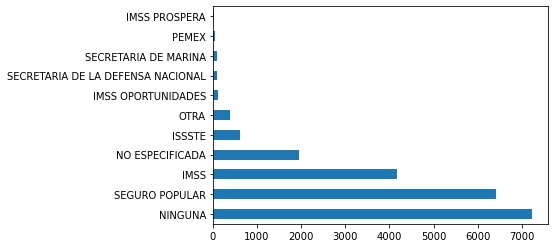

In [9]:
df['[totales].[$afiliacion.afiliación derechohabiencia]'].value_counts().plot.barh()

<AxesSubplot:>

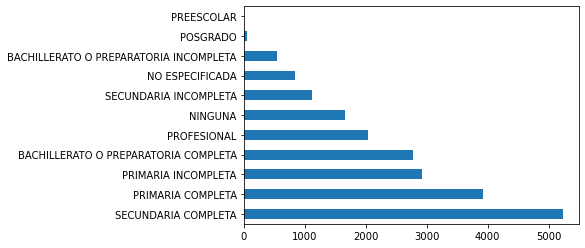

In [10]:
df['[totales].[$escolaridad.escolaridad]'].value_counts().plot.barh()

<AxesSubplot:>

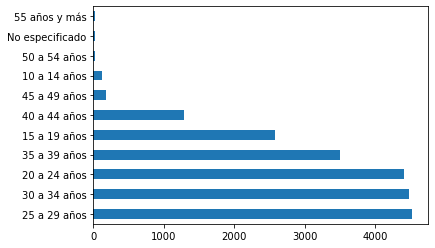

In [11]:
df['[totales].[$edad.edad quinquenal]'].value_counts().plot.barh()

* Con MDX podemos hacer consultas seleccionando filtrando algunas columnas con SELECT y o también filtrando filas con WHERE:

In [12]:
cursor.execute("""
SELECT [$mes registro.mes de registro], [$afiliacion.afiliación derechohabiencia]
FROM [MUERTES MATERNAS].[MEASURES]
WHERE [$mes registro.mes de registro]="MAYO"
""")
rows = cursor.fetchall()
rows_to_df(rows)

,[totales].[$mes registro.mes de registro],[totales].[$afiliacion.afiliación derechohabiencia],_id
0,MAYO,SEGURO POPULAR,0
1,MAYO,SEGURO POPULAR,1
2,MAYO,SEGURO POPULAR,2
3,MAYO,IMSS PROSPERA,3
4,MAYO,SEGURO POPULAR,4
...,...,...,...
1686,MAYO,OTRA,1686
1687,MAYO,NINGUNA,1687
1688,MAYO,IMSS,1688
1689,MAYO,IMSS,1689


# Segundo ejemplo: cubo de nacimientos

* De la lista de cubos disponibles, seleccionamos el de NACIMIENTOS_2022

In [13]:
cubo2 = 'NACIMIENTOS_2022'
conn2 = adodbapi.connect('Provider=MSOLAP.8;Password=Temp123!;Persist Security Info=True;User ID=SALUD\DGIS15;'
                        f'Data Source=pwidgis03.salud.gob.mx;Update Isolation Level=2;Initial Catalog={cubo2}')
cursor2 = conn2.cursor()

* revisamos las dimensiones que tiene este cubo:

In [14]:
cursor2.execute("""
SELECT [CATALOG_NAME] as [DATABASE],
CUBE_NAME AS [CUBE], DIMENSION_CAPTION AS [DIMENSION]
FROM $system.MDSchema_Dimensions
""")
rows = cursor2.fetchall()
df_cubos_nacimiento = rows_to_df(rows)
df_cubos_nacimiento

,database,cube,dimension,_id
0,NACIMIENTOS_2022,$01 UNIDADMEDICA PARTO,01 UNIDADMEDICA PARTO,0
1,NACIMIENTOS_2022,$01 UNIDADMEDICA PARTO,Measures,1
2,NACIMIENTOS_2022,$02 FECHA DE NACIMIENTO,02 FECHA DE NACIMIENTO,2
3,NACIMIENTOS_2022,$02 FECHA DE NACIMIENTO,Measures,3
4,NACIMIENTOS_2022,$APGARH,APGARH,4
...,...,...,...,...
124,NACIMIENTOS_2022,NACIMIENTOS_2022,SOBREVIVIO PARTO,124
125,NACIMIENTOS_2022,NACIMIENTOS_2022,TAMIZ Y VACUNAS,125
126,NACIMIENTOS_2022,NACIMIENTOS_2022,TRABAJA ACTUALMENTE,126
127,NACIMIENTOS_2022,NACIMIENTOS_2022,TRIMESTRE PRIMER CONSULTA,127


* el cubo de interés es "NACIMIENTOS_2022"

In [15]:
df_cubos_nacimiento.query('cube=="NACIMIENTOS_2022"')

,database,cube,dimension,_id
86,NACIMIENTOS_2022,NACIMIENTOS_2022,01 UNIDAD MEDICA PARTO,86
87,NACIMIENTOS_2022,NACIMIENTOS_2022,02 FECHA DE NACIMIENTO,87
88,NACIMIENTOS_2022,NACIMIENTOS_2022,APGARH,88
89,NACIMIENTOS_2022,NACIMIENTOS_2022,ATENCION PRENATAL,89
90,NACIMIENTOS_2022,NACIMIENTOS_2022,CERTIFICADO POR,90
91,NACIMIENTOS_2022,NACIMIENTOS_2022,CODIGO CIE,91
92,NACIMIENTOS_2022,NACIMIENTOS_2022,CONDICIONHIJOANTERIOR,92
93,NACIMIENTOS_2022,NACIMIENTOS_2022,CUENTA CON CURP,93
94,NACIMIENTOS_2022,NACIMIENTOS_2022,DERECHOHABIENCIA,94
95,NACIMIENTOS_2022,NACIMIENTOS_2022,EDAD DE LA MADRE,95


* Si intentamos seleccionar todos los datos del cubo, nos aparece un error porque parece que la carga es mucha y el tiempo de consulta se agota.

In [16]:
cursor2.execute("""
SELECT *
FROM [NACIMIENTOS_2022].[Measures]
""")
rows = cursor2.fetchall()
rows_to_df(rows)

DatabaseError: (-2147352567, 'Ocurrió una excepción.', (0, 'Microsoft OLE DB Provider for Analysis Services.', 'XML for Analysis parser: The XML for Analysis request timed out before it was completed.', None, 0, -2147467259), None)
Command:

SELECT *
FROM [NACIMIENTOS_2022].[Measures]

Parameters:
[]

* Para poder hacer la consulta, la opción es hacer varias consultas más pequeñas, por ejemplo, una para cada entidad federativa. Revisemos las entidades federativas disponibles

In [17]:
cursor2.execute("""
SELECT entidadresidenciad
FROM [NACIMIENTOS_2022].[$ENTIDAD_RESIDENCIA]
""")
rows = cursor2.fetchall()
rows_to_df(rows)

,[$entidad_residencia].[entidadresidenciad],_id
0,00 NO ESPECIFICADO,0
1,01 AGUASCALIENTES,1
2,02 BAJA CALIFORNIA,2
3,03 BAJA CALIFORNIA SUR,3
4,04 CAMPECHE,4
5,05 COAHUILA DE ZARAGOZA,5
6,06 COLIMA,6
7,07 CHIAPAS,7
8,08 CHIHUAHUA,8
9,09 CIUDAD DE MEXICO,9


* entonces ahora solo seleccionamos la de un estado en particular, por ejemplo, Chiapas

In [18]:
cursor2.execute("""
SELECT *
FROM [NACIMIENTOS_2022].[Measures]
WHERE [$ENTIDAD_RESIDENCIA.entidadresidenciad]="07 CHIAPAS"
""")
rows = cursor2.fetchall()
df_nacimientos_chis = rows_to_df(rows)
df_nacimientos_chis

,[nacimientos].[$atencion prenatal.atencion prenatal],[nacimientos].[$certificado por.certificado por],[nacimientos].[$condicionhijoanterior.condicion hijo anterior],[nacimientos].[$producto.productoembarazo],[nacimientos].[$entidad de captura.entidad de captura],[nacimientos].[$estado conyugal.situacion conyugal],[nacimientos].[$se considera indigena.seconsideraindigena],[nacimientos].[$lugar nacimiento.lugar de nacimiento],[nacimientos].[$personal atendio.personal que atendio],[nacimientos].[$tamiz y vacunas.tamizauditivo],...,[nacimientos].[$ocupacion_habitual.ocupacion habitual],[nacimientos].[$entidad_parto.entidadfederativaparto],[nacimientos].[$entidad_residencia.entidadresidencia],[nacimientos].[$entidad_nacimiento_madre.entidadnacimiento],[nacimientos].[$edad gestacional.edad gestacional],[nacimientos].[$derechohabiencia.derechohabiencia],[nacimientos].[$escolaridad.escolaridad],[nacimientos].[$pais_origen.pais de origen],[nacimientos].[nacimientos],_id
0,SI,OTRO MÉDICO,NO HA TENIDO OTROS HIJOS(AS),ÚNICO,07 CHIAPAS,UNION LIBRE,NO,SECRETARÍA DE SALUD,MÉDICO,NO,...,"NO REMUNERADO, AMA DE CASA",0001 TUXTLA GUTIERREZ,0062,061,40,NINGUNA,BACHILLERATO O PREPARATORIA COMPLETA,MEXICO,1,0
1,SI,OTRO MÉDICO,VIVO,ÚNICO,07 CHIAPAS,UNION LIBRE,NO,SECRETARÍA DE SALUD,MÉDICO,NO,...,"NO REMUNERADO, AMA DE CASA",0001 TUXTLA GUTIERREZ,0001,003,41,NINGUNA,PRIMARIA COMPLETA,MEXICO,1,1
2,SI,OTRO MÉDICO,NO HA TENIDO OTROS HIJOS(AS),ÚNICO,07 CHIAPAS,UNION LIBRE,NO,HOGAR,PARTERA,NO,...,"NO REMUNERADO, AMA DE CASA",0001 MOTOZINTLA DE MENDOZA,0001,070,40,NINGUNA,BACHILLERATO O PREPARATORIA COMPLETA,MEXICO,1,2
3,SI,PERSONA AUTORIZADA POR LA SECRETARÍA DE SALUD,VIVO,ÚNICO,07 CHIAPAS,UNION LIBRE,NO,IMSS BIENESTAR,MÉDICO,NO,...,"NO REMUNERADO, AMA DE CASA",0001 MOTOZINTLA DE MENDOZA,0063,057,39,SE IGNORA,BACHILLERATO O PREPARATORIA COMPLETA,MEXICO,1,3
4,SI,OTRO MÉDICO,VIVO,ÚNICO,07 CHIAPAS,UNION LIBRE,SI,SECRETARÍA DE SALUD,MÉDICO,NO,...,NO ESPECIFICADO,0001 CHALCHIHUITAN,0043,022,39,NINGUNA,SECUNDARIA COMPLETA,MEXICO,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35819,SI,OTRO MÉDICO,VIVO,ÚNICO,07 CHIAPAS,UNION LIBRE,NO,SECRETARÍA DE SALUD,MÉDICO,NO,...,"NO REMUNERADO, AMA DE CASA",0001 TUXTLA GUTIERREZ,1017,020,40,NINGUNA,BACHILLERATO O PREPARATORIA COMPLETA,MEXICO,1,35819
35820,SI,OTRO MÉDICO,VIVO,ÚNICO,07 CHIAPAS,UNION LIBRE,NO,SECRETARÍA DE SALUD,MÉDICO,NO,...,"NO REMUNERADO, AMA DE CASA",0001 HUIXTLA,0225,071,39,NINGUNA,SECUNDARIA COMPLETA,MEXICO,1,35820
35821,SI,MÉDICO PEDIATRA,VIVO,ÚNICO,07 CHIAPAS,UNION LIBRE,NO,SECRETARÍA DE SALUD,MÉDICO,NO,...,"NO REMUNERADO, AMA DE CASA",0001 TAPACHULA DE CORDOVA Y ORDOÑEZ,0001,997,40,NINGUNA,PRIMARIA COMPLETA,GUATEMALA,1,35821
35822,SI,MÉDICO PEDIATRA,NO HA TENIDO OTROS HIJOS(AS),ÚNICO,07 CHIAPAS,CASADO(A),NO,SECRETARÍA DE SALUD,MÉDICO,NO,...,"NO REMUNERADO, AMA DE CASA",0001 COMITAN DE DOMINGUEZ,0085,104,38,NINGUNA,BACHILLERATO O PREPARATORIA COMPLETA,MEXICO,1,35822


In [19]:
df_nacimientos_chis.columns

Index(['[nacimientos].[$atencion prenatal.atencion prenatal]',
       '[nacimientos].[$certificado por.certificado por]',
       '[nacimientos].[$condicionhijoanterior.condicion hijo anterior]',
       '[nacimientos].[$producto.productoembarazo]',
       '[nacimientos].[$entidad de captura.entidad de captura]',
       '[nacimientos].[$estado conyugal.situacion conyugal]',
       '[nacimientos].[$se considera indigena.seconsideraindigena]',
       '[nacimientos].[$lugar nacimiento.lugar de nacimiento]',
       '[nacimientos].[$personal atendio.personal que atendio]',
       '[nacimientos].[$tamiz y vacunas.tamizauditivo]',
       '[nacimientos].[$sexo.sexo]',
       '[nacimientos].[$sobrevivio parto.sobrevivio al parto]',
       '[nacimientos].[$trabaja actualmente.trabaja actualmente]',
       '[nacimientos].[$trimestre primer consulta.trimestre primer consulta]',
       '[nacimientos].[$hijos nacidos muertos.hijosnacidosmuertosc]',
       '[nacimientos].[$hijos sobrevivientes.hijos so

En este último caso quizá convenga aprender mejor MDX para hacer consultas más detalladas y con menos resultados. La verdad a mí me pareció un lenguaje complicado, pero es necesario entenderlo un poco para poder usar los cubos dinámicos. Yo tuve muchísimos errores antes de poder dar con las consultas correctas que hice arriba.